<h1>Quora Question Pairs(Kaggle+AppliedAI)</h1>


Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

Currently, Quora uses a Random Forest model to identify duplicate questions. In this competition, Kagglers are challenged to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not. Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers.

- Source: https://www.kaggle.com/c/quora-question-pairs

<h1> Problem Statement</h1>

The goal of this task is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.



<h1> Data Description</h1> 

Two csv file has been given - Train.csv and test.csv
<h2> Data Fields</h2> 

- id - the id of a training set question pair
- qid1, qid2 - unique ids of each question (only available in train.csv)
- question1, question2 - the full text of each question
- is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

<h1> Performance metrics </h1>

- Log loss
    
- Confusion matrix

### Importing Libraries

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
import re
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objs as go
import plotly.tools as tls

In [73]:
data=pd.read_csv("train.csv")


In [74]:
print("Number of data points = ",data.shape[0])
print("Name of columns present = ",data.columns)

Number of data points =  404290
Name of columns present =  Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')


In [75]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [76]:
# Is there any null value present in data frame
print(" Is there any null value present in the dataframe: ",data.isnull().values.any())
data[data.isnull().any(1)]


 Is there any null value present in the dataframe:  True


,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [77]:
# Putting " " in the null values
data=data.fillna(" ")
data[data.isnull().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate


In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404290 non-null  object
 4   question2     404290 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


Number of questions pair are duplicate in the given dataframe :  255027
Number of questions pair are not duplicate in the given dataframe:  149263


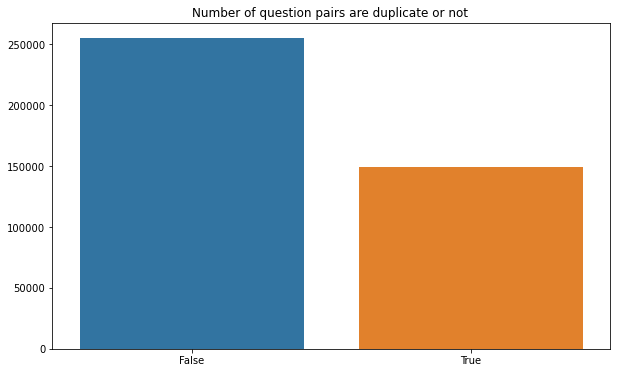

In [79]:
# Finding number of questions are dupliclate
print("Number of questions pair are duplicate in the given dataframe : ",data.groupby("is_duplicate").id.agg(len)[0])
print("Number of questions pair are not duplicate in the given dataframe: ",data.groupby("is_duplicate").id.agg(len)[1])
y=[data.groupby("is_duplicate").id.count()[0],data.groupby("is_duplicate").id.count()[1]]
x=["False","True"]
plt.figure(figsize=(10, 6))
plt.title ("Number of question pairs are duplicate or not ")
sns.barplot(x,y)
plt.show()


# Feature Extraction

In [80]:
data['freq_qid1']=data.groupby('qid1')['qid1'].transform('count')
data['freq_qid2']=data.groupby('qid2')['qid2'].transform('count')
data['q1len']=data['question1'].str.len()
data['q2len']=data['question2'].str.len()
data['q1_n_words1']=data['question1'].apply(lambda row:len(row.split(" ")))
data['q1_n_words2']=data['question2'].apply(lambda row:len(row.split(" ")))
def normalized_word_common(row):
    w1=set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
    w2=set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
    return(1.0*len(w1 & w2))
def normalized_word_total(row):
    w1=set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
    w2=set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
    return(1.0*len(w1) + len(w2))
def normalized_word_share(row):
    w1=set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
    w2=set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
    return(1.0*(len(w1 & w2)/(len(w1) + len(w2))))
data['word_common']= data.apply(normalized_word_common,axis=1)
data['word_total']= data.apply(normalized_word_total,axis=1)
data['word_share']= data.apply(normalized_word_share,axis=1)
data['freq_q1+q2'] = data['freq_qid1']+data['freq_qid2']
data['freq_q1-q2'] = abs(data['freq_qid1']-data['freq_qid2'])

In [81]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words1,q1_n_words2,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


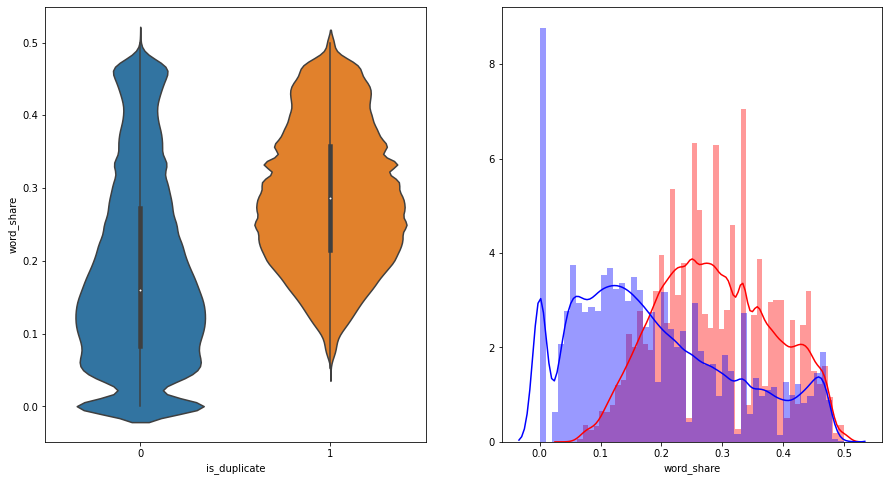

In [82]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=data)\

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['word_share'] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['word_share'] , label = "0" , color = 'blue' )
plt.show()

In [83]:
nltk.download('stopwords')
Stop_words=stopwords.words("english")
def textpreprocess(x):
    x=str(x).lower()
    x=x.replace(",000,000","m").replace(",000","k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

[nltk_data] Downloading package stopwords to C:\Users\MD DANISH
[nltk_data]     ANWER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [84]:
data['question1']= data['question1'].apply(textpreprocess)
data['question2']= data['question2'].apply(textpreprocess)

In [85]:
SAFE_DIV = 0.0001
def get_token_features(q1,q2):
    token_features=[0.0]*10
    q1_tokens=q1.split()
    q2_tokens=q2.split()
    if len(q1_tokens)==0 or len(q2_tokens)==0:
        return token_features
    q1_words=set([word for word in q1_tokens if word not in Stop_words])
    q2_words=set([word for word in q2_tokens if word not in Stop_words])
    q1_stops=set([word for word in q1_tokens if word in Stop_words])
    q2_stops=set([word for word in q2_tokens if word in Stop_words])
    common_word_count = len(q1_words.intersection(q2_words))
    common_stop_count= len(q1_stops.intersection(q2_stops))
    common_token_count=len(set(q1_tokens).intersection(set(q2_tokens)))
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features
    

In [86]:
def get_longest_substr_ratio(a, b):
    q1word=a.split()
    q2word=b.split()
    common_word_length=len(set(q1word).intersection(set(q2word)))
    if common_word_length==0:
        return 0
    else:
        return (common_word_length)/(min(len(q1word),len(q2word))+1)
    
def extract_features(df):
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    df["token_set_ratio"]  = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [87]:
data=extract_features(data)

In [88]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.846154
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.636364
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.363636
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.000000
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.500000


# Analysis of extracted features </h3>

In [89]:
data_duplicate=data[data['is_duplicate']==1]
data_notduplicate=data[data['is_duplicate']==0]

Word Cloud for Duplicate Question pairs


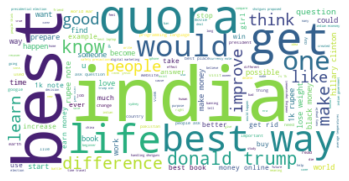

In [119]:
pos=np.dstack([data_duplicate["question1"], data_duplicate["question2"]]).flatten()
neg=np.dstack([data_notduplicate["question1"], data_notduplicate["question2"]]).flatten()
str=" "
for i in pos:
    str=str+i
wc = WordCloud(background_color="white", stopwords=Stop_words)
wc.generate(str)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()    

Word Cloud for Duplicate Question pairs


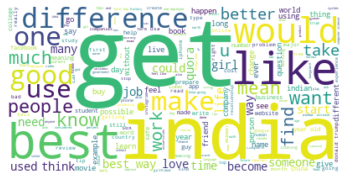

In [120]:
str=" "
for i in neg:
    str=str+i
wc = WordCloud(background_color="white", stopwords=Stop_words)
wc.generate(str)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()   

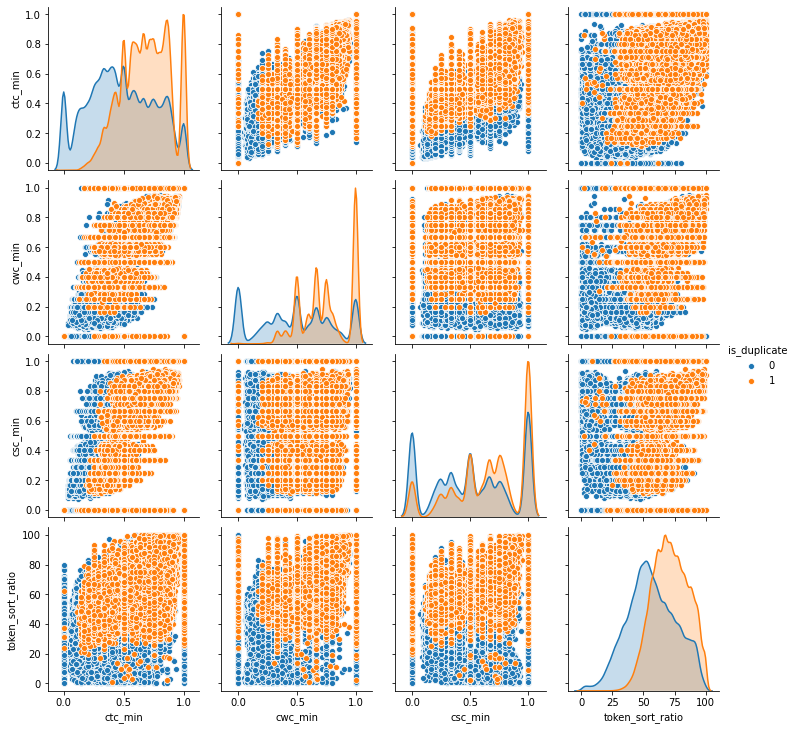

In [121]:
n = data.shape[0]
sns.pairplot(data[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

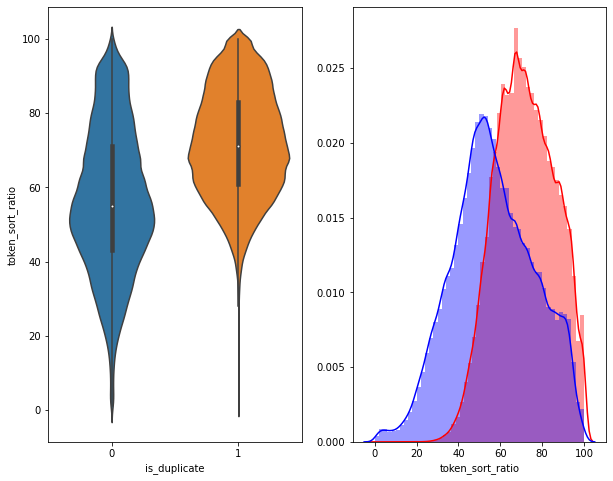

In [123]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = data[0:] , )

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(data[data['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

In [124]:

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = data[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [125]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.054s...
[t-SNE] Computed neighbors for 5000 samples in 0.438s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.123399
[t-SNE] Computed conditional probabilities in 0.244s
[t-SNE] Iteration 50: error = 80.9445114, gradient norm = 0.0392434 (50 iterations in 0.968s)
[t-SNE] Iteration 100: error = 70.3205872, gradient norm = 0.0099122 (50 iterations in 0.842s)
[t-SNE] Iteration 150: error = 68.5008698, gradient norm = 0.0066114 (50 iterations in 0.847s)
[t-SNE] Iteration 200: error = 67.5378418, gradient norm = 0.0045980 (50 iterations in 0.851s)
[t-SNE] Iteration 250: error = 67.0082245, gradient norm = 0.0041327

In [128]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

X=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=X, layout=layout)
py.iplot(fig, filename='3DBubble')

NameError: name 'tsne3d' is not defined